In [1]:
import os
import random
from operator import itemgetter
from typing import List, Tuple, Any, TypeVar
from pathlib import Path
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy.stats import randint, uniform, loguniform
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             average_precision_score, roc_auc_score)

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

SEED = 42
T = TypeVar("T", bound="DataCleaner")

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# Utilities

In [19]:
def display_random_sample(data: List[str],
                          target_variable: np.ndarray,
                          labels: List[str],
                          n_samples: int = 1,
                          target_class: str = None
                         ) -> None:
    """Easy display random sample(s) from all the data or from a selected class"""
    if target_class is not None:
        filtered_indices = [i for i, label in enumerate(target_variable)
                            if label == target_class]
        if not filtered_indices:
            print(f"No samples found for class {target_class}")
            return
        data = list(itemgetter(*filtered_indices)(data))
        target_variable = list(itemgetter(*filtered_indices)(target_variable))
    
    sampled_indices = random.sample(range(len(data)), k=n_samples)
    
    for i in sampled_indices:
        label = labels[target_variable[i]]
        print(f"Label: {label}\n\nMessage:\n{data[i]}\n")


def check_empty_samples(X_train: List[str],
                        X_test: List[str]
                       ) -> Tuple[np.ndarray]:
    """Check if there are any empty strings in data."""
    empty_train_indices = [idx for idx, string in enumerate(X_train)
                           if string in ["", " "]]
    empty_test_indices = [idx for idx, string in enumerate(X_test)
                          if string in ["", " "]]
    
    return empty_train_indices, empty_test_indices


def remove_empty_samples(X: List[str], y: np.ndarray, indices: List[int]
                        ) -> Tuple[List[str], np.ndarray]:
    """Remove empty string samples."""
    X, y = X.copy(), y.copy()
    for idx in reversed(indices):
        del X[idx]
        y = np.delete(y, idx)

    return X, y


class DataCleaner:

    def __init__(self,
                 data: List[str] = None,
                 to_remove_patterns: List[str] = [],
                 to_remove_words: List[str] = [],
                 token_pattern: str = r"(?u)\b\w[\w']*\b"
                ) -> None:
        self.data = data.copy() if data is not None else None
        self.to_remove_patterns = to_remove_patterns
        self.to_remove_words = to_remove_words
        self.token_pattern = token_pattern
        self.stop_words = stopwords.words("english")
        self.lemmatizer = WordNetLemmatizer()

    def remove_substrings_from_patterns(self: T) -> T:
        "Remove substrings found as unwanted token patterns."
        for pattern in self.to_remove_patterns:
            self.data = [pattern.sub("", message) for message in self.data]

        return self
    
    def remove_substrings_from_list(self: T) -> T:
        """Tokenize, remove unwanted words and lowercase all."""
        
        pre_cleaned = []
        
        for message in self.data:
            tokens = re.findall(self.token_pattern, message)
            cleaned_message = [w.lower() for w in tokens
                               if w.lower() not in self.stop_words + self.to_remove_words]
            pre_cleaned.append(cleaned_message)

        self.data = pre_cleaned
    
        return self       
    
    def lemmatize_data(self: T) -> T:
        """Lemmatize tokenized messages and join into strings."""
    
        for i in range(len(self.data)):
            lemmatized_message = [self.lemmatizer.lemmatize(token) for token in self.data[i]]
            self.data[i] = " ".join(lemmatized_message)
    
        return self

    def transform(self: T, data: List[str] = None) -> List[str]:
        """Transform data with cleaning and lemmatization"""
        if data is not None:
            self.data = data.copy()
        self.remove_substrings_from_patterns()
        self.remove_substrings_from_list()
        self.lemmatize_data()
        
        return self.data


def get_metrics(cv_results: dict,
                main_metric: str = None,
                other_metrics: List[str] = None
               ) -> dict:
    """Get metrics from `cv_results_` dict provided by RandomizedSearchCV optimizer."""
    metrics = {}
    if main_metric is None:
        main_metric = "f1_macro"
    if other_metrics is None:
        other_metrics = ["f1_weighted", "accuracy"]
    
    best_index = np.argmax(cv_results[f"mean_test_{main_metric}"])

    best_score = cv_results[f"mean_test_{main_metric}"][best_index]
    best_score_train = cv_results[f"mean_train_{main_metric}"][best_index]

    metrics[main_metric] = best_score
    metrics[f"{main_metric}_train"] = best_score_train

    for metric in other_metrics:
        corresponding_metric_test = cv_results[f"mean_test_{metric}"][best_index]
        corresponding_metric_train = cv_results[f"mean_train_{metric}"][best_index]
        metrics[metric] = corresponding_metric_test
        metrics[f"{metric}_train"] = corresponding_metric_train

    metrics["time[s]"] = np.round((cv_results["mean_fit_time"][best_index]
                                   + cv_results["mean_score_time"][best_index]).mean(), 2)

    return metrics


def load_results(endswith: str,
                 directory: str = "results"
                ) -> Tuple[List[Any], List[str]]:
    """"""
    object_list = []
    name_list = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(endswith):
                file_path = os.path.join(root, file)
                object_ = load(file_path)
                object_list.append(object_)
                
                subfolder = os.path.basename(root)
                file_prefix = file[:3]
                name = f"{subfolder}_{file_prefix}"
                name_list.append(name)

    return object_list, name_list

# The dataset

In [3]:
loading_data_params = {"remove": ("headers", "footers", "quotes"),
                       "return_X_y": True,
                       "random_state": SEED}

train = fetch_20newsgroups(data_home="data/train", subset="train")
X_train, y_train = fetch_20newsgroups(data_home="data/train", subset="train", **loading_data_params)
X_test, y_test = fetch_20newsgroups(data_home="data/test", subset="test", **loading_data_params)

## Content

In [4]:
print(train.DESCR[26:395])
print(train.DESCR[846:1050])


The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1
Features                  text


In [5]:
labels = dict(zip(range(20), train.target_names))
pd.DataFrame.from_dict(labels, orient="index", columns=["target_name"])

,target_name
0,alt.atheism
1,comp.graphics
2,comp.os.ms-windows.misc
3,comp.sys.ibm.pc.hardware
4,comp.sys.mac.hardware
5,comp.windows.x
6,misc.forsale
7,rec.autos
8,rec.motorcycles
9,rec.sport.baseball


In [13]:
display_random_sample(X_train, y_train, labels, n_samples=1, target_class=None)

Label: talk.politics.guns

Message:
/ iftccu:talk.politics.guns / hays@ssd.intel.com (Kirk Hays) /  3:31 pm  Apr 13, 1993 /


Good point, Kirk.

He's still around too.  He's responded by email to a couple of my posts, 
and gosh darn, he's gotten down right civil!  This happed about the time 
he got his first firearm.  Wonder if there is a relationship here?  Turns
out that MOST people (at least the ones who are not criminals to start
with) act responsibility once given the chance.



## Data issues

Although headers, footers, and block quotes were omitted during loading, we identified the following issues in the data:

* empty strings
* mixtures of letters and numbers, such as n3jpx, x11r5
* communication protocol headers like nntp, IP addresses
* words related to message organization, such as: "re", "subject", "organization", "lines", "from", "date", "references", "message", "id", "voice", "fax", "email", "mail"
* email addresses, phone numbers, fax numbers
* names of institutions/companies, addresses, first and last names

## Initial cleaning

Removing samples with empty strings

In [14]:
empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 226 empty strings
X_test: 163 empty strings


In [15]:
X_train, y_train = remove_empty_samples(X_train, y_train, empty_train_indices)
X_test, y_test = remove_empty_samples(X_test, y_test, empty_test_indices)

empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 0 empty strings
X_test: 0 empty strings


## Class distribution

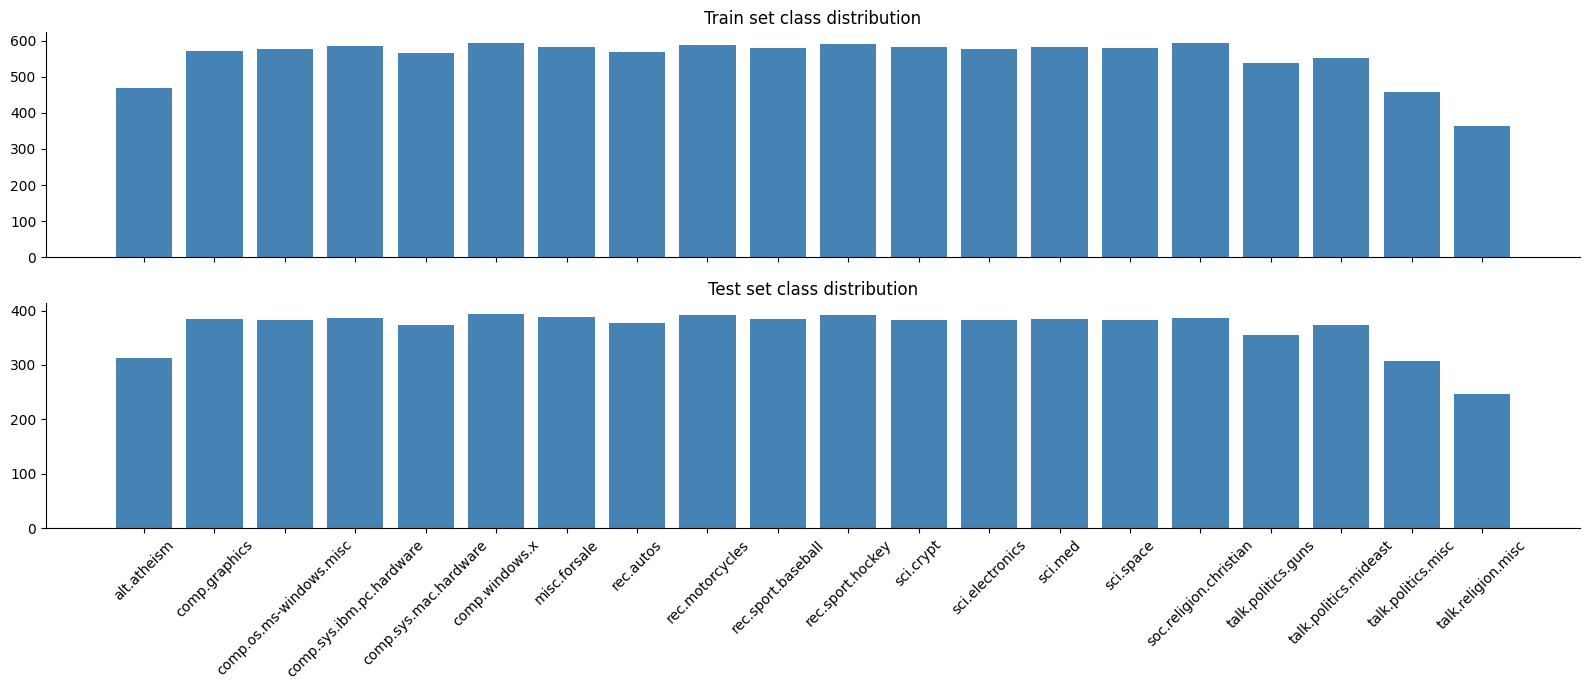

In [16]:
unique, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

fig, axs = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
axs[0].bar(train.target_names, counts_train, color="steelblue")
axs[0].set_title("Train set class distribution")
axs[1].bar(train.target_names, counts_test, color="steelblue")
axs[1].set_title("Test set class distribution")
axs[1].set_xticks(ticks=unique, labels=train.target_names, rotation=45)
plt.tight_layout();

# Classic ML approach

## Data preparing

We created the `DataCleaner` class for convenient transforming our data.

We used regular expressions to remove email adresses, nntp protocol info, numbers and words which are combinations of numbers and letters. We also removed non-informative words we found (like related to messages organization or stop words we didn't find in the list provided by `nltk`)

In [20]:
email_pattern = re.compile("[\w\.]+@\w+\.\w+[\w\.]*")
nntp_pattern = re.compile(r"\b\w*(?:nntp|NNTP)\w*\b")
num_seq_pattern = re.compile(r'\b\d+\b')
num_with_letters = re.compile(r'\b(?=\w*\d)(?=\w*[a-zA-Z])\w{3,}\b')
words_to_remove = ["re", "subject", "organization", "lines", "from", "date",
                   "references", "message", "id", "voice", "fax", "email", "mail",
                   "i'm", "i've", "i'd", "can't", "can"]

cleaner = DataCleaner(to_remove_patterns=[email_pattern,
                                          nntp_pattern,
                                          num_seq_pattern,
                                          num_with_letters],
                      to_remove_words=words_to_remove)

cleaned_X_train = cleaner.transform(X_train)
cleaned_X_test = cleaner.transform(X_test)

In [21]:
vectorizer = TfidfVectorizer()
print(f"Number of unigram features before cleaning: {len(vectorizer.fit(X_train).get_feature_names_out())}")
print(f"After cleaning and lemmatization: {len(vectorizer.fit(cleaned_X_train).get_feature_names_out())}")

Number of unigram features before cleaning: 101631
After cleaning and lemmatization: 63099


In [22]:
bold = "\033[1m"
end_bold = "\033[0m"
for i in random.sample(range(len(X_train)), k=2):
    print(f"{bold}Original message:{end_bold}\n:", X_train[i])
    print(f"{bold}Cleaned message:{end_bold}\n:", cleaned_X_train[i])
    print("-"*72)

Original message:
: 
Because Greyhound has apparently gotten around to installing their
RADAR collision-prevention system. They use RADAR to monitor how close
other vehicles are and how fast their relative speeds are, and signals
a warning to the driver if they're coming up on something too fast
or are getting too close.

This is all I remember from the news reports a few months back; at
the time, they were only talking about the possibility of installing
the system. (They didn't mention how it worked in bumper-to-bumper
traffic, or how it discriminated between a Camaro approaching at
120mph and ye olde bridge support in the median being approached 
at 60mph on a curve.)

I do recall something about progressive stages of warnings, from
flashing lights to audible warnings--ie, it goes from a red "Too
close" light to hysterically screaming "WE'RE ALL GOING TO DIE!!!!"  :-)

				James
Cleaned message:
: greyhound apparently gotten around installing radar collision prevention system use ra

## Hyperparameters optimization

We want to test two approaches:
* the first one: cleaned and lemmatized data with feature selection using chi square test
* the second one: unchanged data with feature selection by `TfidfVectorizer` parameters

We optimized hyperparameters by randomized search with 5-fold cross validion. Our main scoring metric is `F1 macro` (the average `F1 score` of all classes), as we want to have accurate predictions for all of 20 classes. To see bigger picture, we also saved `F1 weighted`, to verify if that little imbalance affects our scores, and general accuracy.

### Defining Pipeline and hyperparameters grids

In [19]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("selector", "passthrough"),
    ("model", "passthrough")
])

chi2_selection_grid = {
    "vectorizer__stop_words": [None],
    "selector": [SelectKBest(chi2)],
    "selector__k": randint(1000, 5000)
}

vectorizer_selection_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": ["english", None],
    "vectorizer__min_df": randint(1, 5),
    "vectorizer__max_df": uniform(0.5, 0.5),
    "vectorizer__max_features": randint(1000, 5000)
}

mnb_base_grid = {
    "model": [MultinomialNB()],
    "model__alpha": uniform(0.5, 0.5),
}

svm_base_grid = {
    "model": [SVC(random_state=SEED)],
    "model__kernel": ["linear"],
    "model__C": loguniform(1e-4, 1e1),
    "model__class_weight": ["balanced", None]
}

mnb_grids = [
    {
        **mnb_base_grid,
        **chi2_selection_grid
    },
    {
        **mnb_base_grid,
        **vectorizer_selection_grid
    }
]

svm_grids = [
    {
        **svm_base_grid,
        **chi2_selection_grid
    },
    {
        **svm_base_grid,
        **vectorizer_selection_grid
    }
]

### Run experiments

* defining cross validation scheme
* designing code to easily test both approaches (and data versions) for both our models with different parameters
* providing `n_iter` parameter depending on model (we set more iterations for `MultinomialNB` as it learns so much faster)
* saving our best models' artifacts and metrics (and cv_results_ for possible analysis if needed)

In [21]:
cv_scheme = KFold(n_splits=5, shuffle=True, random_state=SEED)

for name, grids in zip(["MNB", "SVC"],
                       [mnb_grids, svm_grids]):

    n_iter = 300 if name == "MNB" else 150

    for X, test, grid in zip([cleaned_X_train, X_train],
                             ["cleaned_data", "full_data"],
                              grids):
    
        optimizer = RandomizedSearchCV(pipeline,
                                       grid,
                                       scoring=["f1_macro", "f1_weighted", "accuracy"],
                                       refit="f1_macro",
                                       n_iter=n_iter,
                                       cv=cv_scheme,
                                       return_train_score=True,
                                       n_jobs=-1,
                                       error_score="raise",
                                       verbose=1,
                                       random_state=SEED
                                       )
    
        optimizer.fit(X, y_train)
    
        path = Path("results", test)
        path.mkdir(parents=True, exist_ok=True)
        
        metrics = get_metrics(optimizer.cv_results_)
        model = optimizer.best_estimator_
    
        dump(metrics, f"{path}/{name}_metrics.pkl")
        dump(model, f"{path}/{name}_model.pkl")
        dump(optimizer.cv_results_, f"{path}/{name}_cv_results.pkl")
        
        print(optimizer.best_score_)
        print(optimizer.best_params_)
        print("--------------------")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.7123846603483618
{'model': MultinomialNB(), 'model__alpha': 0.5194173672147115, 'selector': SelectKBest(score_func=<function chi2 at 0x7a8407786310>), 'selector__k': 4854, 'vectorizer__stop_words': None}
--------------------
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.6865507259852466
{'model': MultinomialNB(), 'model__alpha': 0.6027899041878187, 'vectorizer__max_df': 0.8938949443572461, 'vectorizer__max_features': 4737, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}
--------------------
Fitting 5 folds for each of 150 candidates, totalling 750 fits
0.724761662396663
{'model': SVC(random_state=42), 'model__C': 1.2193011993958955, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'selector': SelectKBest(score_func=<function chi2 at 0x7a8407786310>), 'selector__k': 4643, 'vectorizer__stop_words': None}
--------------------
Fitting 5 folds f

### Optimization results



In [23]:
metrics, idxs = load_results(endswith="metrics.pkl")

metrics_df = pd.DataFrame(metrics, index=idxs).round(3)
metrics_df.style.background_gradient()

,f1_macro,f1_macro_train,f1_weighted,f1_weighted_train,accuracy,accuracy_train,time[s]
cleaned_data_MNB,0.712000,0.830000,0.726000,0.839000,0.733000,0.842000,1.930000
cleaned_data_SVC,0.725000,0.887000,0.731000,0.888000,0.728000,0.887000,19.100000
full_data_MNB,0.687000,0.841000,0.700000,0.849000,0.708000,0.852000,2.820000
full_data_SVC,0.679000,0.950000,0.688000,0.951000,0.688000,0.951000,35.880000


# Models' evaluation on test data

In [24]:
models, names = load_results(endswith="model.pkl")

# assigning names to loaded models
for name, model in zip(names, models):
    exec(f"{name} = model")

As we need probabilities to be returned by models to calculate the ROC AUC score and average precision, an additional parameter was set in the SVM, and the SVM models were fitted again. Setting this parameter at the beginning would result in even longer fit and score times, which we didn't want during optimization.

In [25]:
param = {"model__probability": True}

full_data_SVC.set_params(**param)
full_data_SVC.fit(X_train, y_train)

cleaned_data_SVC.set_params(**param)
cleaned_data_SVC.fit(cleaned_X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('selector',
                 SelectKBest(k=4643,
                             score_func=<function chi2 at 0x7385e13653a0>)),
                ('model',
                 SVC(C=1.2193011993958955, class_weight='balanced',
                     kernel='linear', probability=True, random_state=42))])

In [14]:
all_results = []

for name, model in zip(names, models):

    results = {}
    
    X_train_final = X_train if name.startswith("full") else cleaned_X_train
    X_test_final = X_test if name.startswith("full") else cleaned_X_test
    
    y_fitted = model.predict(X_train_final)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)

    results = {
        "F1_macro": f1_score(y_test, y_pred, average="macro"), 
        "F1_macro_train": f1_score(y_train, y_fitted, average="macro"),
        "F1_weighted": f1_score(y_test, y_pred, average="weighted"),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Avg_precision": average_precision_score(y_test, y_proba, average="macro"),
        "Roc_auc_ovr": roc_auc_score(y_test, y_proba, average="macro", multi_class="ovr"),
        "Roc_auc_ovo": roc_auc_score(y_test, y_proba, average="macro", multi_class="ovo")
    }
    all_results.append(results)

results_df = pd.DataFrame(all_results, index=names).round(3)
results_df.style.background_gradient()

,F1_macro,F1_macro_train,F1_weighted,Accuracy,Avg_precision,Roc_auc_ovr,Roc_auc_ovo
cleaned_data_MNB,0.670000,0.822000,0.685000,0.693000,0.704000,0.957000,0.956000
cleaned_data_SVC,0.661000,0.878000,0.671000,0.666000,0.714000,0.953000,0.952000
full_data_MNB,0.642000,0.829000,0.655000,0.663000,0.693000,0.954000,0.953000
full_data_SVC,0.621000,0.944000,0.631000,0.630000,0.672000,0.945000,0.944000


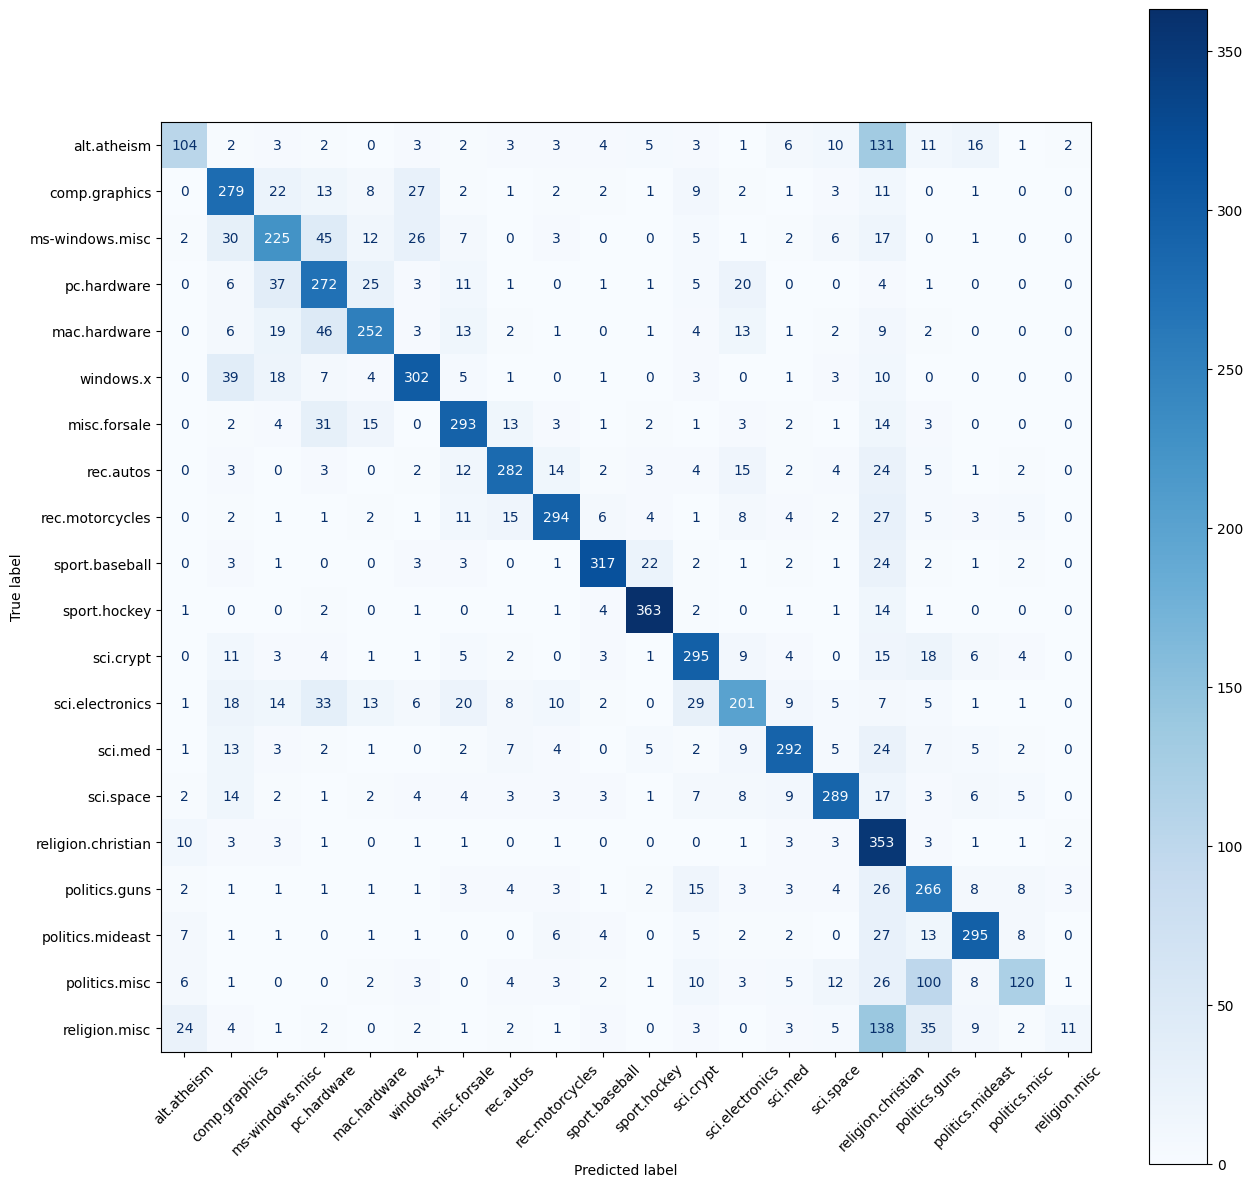

In [26]:
y_pred = cleaned_data_MNB.predict(cleaned_X_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ConfusionMatrixDisplay(cm, display_labels=[".".join((l.split(".")[-2:])) for l in train.target_names]).plot(cmap="Blues", ax=ax)
plt.gca().spines[["right", "top"]].set_visible(True)
plt.xticks(rotation=45);

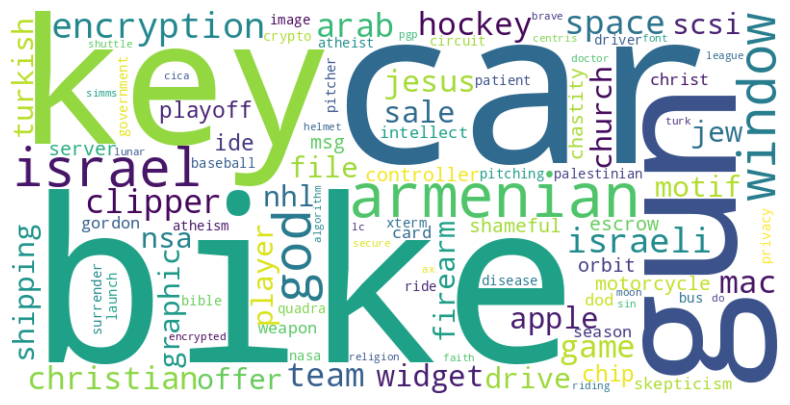

In [27]:
pipeline = cleaned_data_MNB

selector = pipeline.named_steps['selector']
vectorizer = pipeline.named_steps['vectorizer']

feature_names = np.asarray(vectorizer.get_feature_names_out())
top_indices = np.argsort(selector.scores_)[-100:]

top_features = feature_names[top_indices]
top_scores = selector.scores_[top_indices]

feature_scores = dict(zip(top_features, top_scores))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(feature_scores)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()